In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Dec 21 17:16:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#DCGAN
Code from the paper "Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks". 

#Dataset
I'll be using the CelebA dataset as the ground truth for the probability distribution. The GAN will be trained to generate faces.

In [2]:
!gdown --id 12rFbtWMg1NUCW4JKm_dwBpGdb6e-BuHg

Downloading...
From: https://drive.google.com/uc?id=12rFbtWMg1NUCW4JKm_dwBpGdb6e-BuHg
To: /content/CelebA.zip
100% 1.44G/1.44G [00:13<00:00, 109MB/s]


In [3]:
!unzip "/content/CelebA.zip" -d "/content/CelebA"

Streaming output truncated to the last 5000 lines.
 extracting: /content/CelebA/img_align_celeba/197600.jpg  
 extracting: /content/CelebA/img_align_celeba/197601.jpg  
 extracting: /content/CelebA/img_align_celeba/197602.jpg  
 extracting: /content/CelebA/img_align_celeba/197603.jpg  
 extracting: /content/CelebA/img_align_celeba/197604.jpg  
 extracting: /content/CelebA/img_align_celeba/197605.jpg  
 extracting: /content/CelebA/img_align_celeba/197606.jpg  
 extracting: /content/CelebA/img_align_celeba/197607.jpg  
 extracting: /content/CelebA/img_align_celeba/197608.jpg  
 extracting: /content/CelebA/img_align_celeba/197609.jpg  
 extracting: /content/CelebA/img_align_celeba/197610.jpg  
 extracting: /content/CelebA/img_align_celeba/197611.jpg  
 extracting: /content/CelebA/img_align_celeba/197612.jpg  
 extracting: /content/CelebA/img_align_celeba/197613.jpg  
 extracting: /content/CelebA/img_align_celeba/197614.jpg  
 extracting: /content/CelebA/img_align_celeba/197615.jpg  
 extr

In [4]:
!pip install tensorflow
!pip install tensorflow_datasets

In [5]:
!sudo du CelebA
!sudo ls CelebA/img_align_celeba | wc -l

1743844	CelebA/img_align_celeba
1743848	CelebA
202599


In [6]:
!pip install opencv-python

(218, 178, 3)


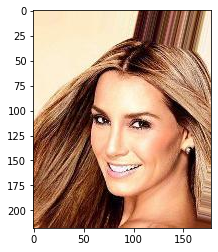

In [7]:
# Test image read

import cv2
import matplotlib.pyplot as plt

# Read in image as ndarray
img = cv2.imread('CelebA/img_align_celeba/000001.jpg')
# BGR -> RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Starting images are 178px resolution
print(img.shape)

# print(img)
plt.imshow(img)

(178, 178, 3)


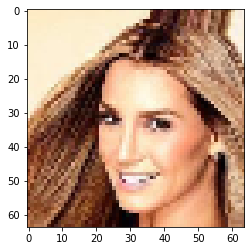

In [8]:

original_img = cv2.imread('CelebA/img_align_celeba/000001.jpg')

# Crop out top and bottom evenly to create a square image
crop_margin = int((original_img.shape[0] - original_img.shape[1]) / 2)
original_img = original_img[crop_margin:(original_img.shape[0] - crop_margin)]

print(original_img.shape)

# Resize to 64x64
img = cv2.resize(original_img, (64, 64))

# BGR -> RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)

In [9]:
!pip install tqdm

In [10]:
# I'm only going to take a subset of the data for now for training

SUBSET_AMOUNT = 10000
SUBSET_AMOUNT = 202599

In [ ]:
import tensorflow as tf

# Load in all file names

directory = r'/content/CelebA/img_align_celeba'
list_ds = tf.data.Dataset.list_files(str(directory/'*/*'), shuffle=True)

In [ ]:
for i in list_ds.take(5):
  print(i.numpy())

In [11]:
# Read images as dataset

import os
import numpy as np
from tqdm import tqdm

ds_list = []

# Image getting and processing callback: 
# from image path, get processed 64x64 image
def img_path2data(img_path):
  
  if img_path.endswith('.jpg'):

    # Read in image as ndarray
    img = cv2.imread(img_path)

    # Crop out top and bottom evenly to create a square image
    crop_margin = int((img.shape[0] - img.shape[1]) / 2)
    img = img[crop_margin:(img.shape[0] - crop_margin)]

    # Resize to 64x64
    img = cv2.resize(img, (64, 64))

    # BGR -> RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Normalize from [0, 255] to [-1, 1]
    img = (img / (255.0/2)) - 1.0

    return img


for filename in tqdm(os.listdir(directory)[:SUBSET_AMOUNT]):

  if filename.endswith('.jpg'):

    # Read in image as ndarray
    img = cv2.imread('CelebA/img_align_celeba/' + filename)

    # Crop out top and bottom evenly to create a square image
    crop_margin = int((img.shape[0] - img.shape[1]) / 2)
    img = img[crop_margin:(img.shape[0] - crop_margin)]

    # Resize to 64x64
    img = cv2.resize(img, (64, 64))

    # BGR -> RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # ds = np.append(ds, img)
    ds_list.append(img)

ds = np.array(ds_list)

100%|██████████| 10000/10000 [00:12<00:00, 819.82it/s]


In [12]:
# Move all pixel values into the range [-1, 1] (the range of tanh)

ds = (ds / (255.0/2)) - 1.0

In [13]:
import tensorflow as tf

BATCH_SIZE = 128

# Batch dataset

dataset = tf.data.Dataset.from_tensor_slices(ds)

dataset = dataset.batch(BATCH_SIZE)

In [14]:
for i in dataset:
  print(i)

Streaming output truncated to the last 5000 lines.
   [ 0.23137255 -0.01176471 -0.4745098 ]
   ...
   [ 0.60784314  0.52941176  0.34117647]
   [ 0.64705882  0.51372549  0.23137255]
   [ 0.43529412  0.30196078 -0.01960784]]

  [[ 0.30196078  0.09803922 -0.36470588]
   [ 0.23137255 -0.01176471 -0.49019608]
   [ 0.43529412  0.15294118 -0.33333333]
   ...
   [ 0.59215686  0.52156863  0.30980392]
   [ 0.44313725  0.34901961  0.04313725]
   [ 0.42745098  0.3254902   0.01960784]]

  [[ 0.38039216  0.17647059 -0.27843137]
   [ 0.2        -0.04313725 -0.50588235]
   [ 0.34117647  0.05882353 -0.42745098]
   ...
   [ 0.57647059  0.49803922  0.27058824]
   [ 0.34901961  0.25490196 -0.05098039]
   [ 0.45098039  0.34117647  0.06666667]]]


 [[[ 0.24705882 -0.04313725 -0.27058824]
   [ 0.51372549  0.20784314 -0.00392157]
   [ 0.49019608  0.17647059 -0.02745098]
   ...
   [ 0.9372549   0.71764706  0.85098039]
   [ 0.94509804  0.69411765  0.81960784]
   [ 0.92156863  0.67058824  0.77254902]]

  [[ 0.31

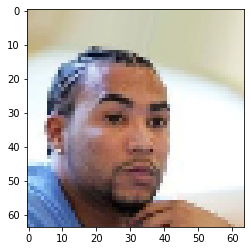

In [15]:
_ = (ds[0]+1.0)/2

plt.imshow(_)

#Training Loop

In [104]:
# Define Generator and Discriminator

import tensorflow as tf

FINAL_DIM = 128
IMAGE_RES = 64
NOISE_DIM = 100

def Generator():
      
  def add_g_layer(x, filters):
    """
    Generator layers are made up of a fractionally-strided convolution 
    ("deconvolution"), BatchNorm, and ReLU activation. 
    """
    x = tf.keras.layers.Conv2DTranspose(filters, kernel_size=(5, 5), 
                                        strides=(2, 2), padding='same', 
                                        activation=None)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    return x

  def output_g_layer(x):
    # Final fractionally-strided convolution ("deconvolution") into image space
    x = tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=(5, 5), 
                                        strides=(2, 2), padding='same', 
                                        activation=None)(x)
    x = tf.math.tanh(x)
    return x

  # Define input noise vector shape
  noise_input = tf.keras.layers.Input(shape=(NOISE_DIM))

  # Initial projection into 4x4 feature maps
  x = tf.keras.layers.Dense(4 * 4 * (FINAL_DIM * 8), 
                            activation=None)(noise_input)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Reshape((4, 4, (FINAL_DIM * 8)))(x)

  # Generator fractionally-strided convolutional layers
  x = add_g_layer(x, filters=FINAL_DIM * 4)
  x = add_g_layer(x, filters=FINAL_DIM * 2)
  x = add_g_layer(x, filters=FINAL_DIM)

  # Final convolution (convert feature maps into image)
  x = output_g_layer(x)

  # Model definition
  model = tf.keras.Model(inputs=noise_input, outputs=x, name='DCGAN_Generator')

  print(model.summary())

  return model


def Discriminator():

  """
  The Discriminator, for the most part, mirrors, the Generator. Key differences
  are 1) LeakyReLU(0.2) instead of ReLU, and 2) Output FC layer(1) with sigmoid
  activation.
  """

  def add_d_layer(x, filters):
    """
    Discriminator layers are made up of a strided convolutional layer 
    (downsampling without pooling), BatchNorm, and LeakyReLU (leak=0.2)
    """
    x = tf.keras.layers.Conv2D(filters, kernel_size=(5, 5), strides=(2, 2), 
                               padding='same', activation=None)(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    return x

  def output_d_layer(x):
    """
    Final layer in Discriminator. Single neuron with sigmoid activation for
    classification of image as fake or real. 
    """
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1)(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    x = tf.math.sigmoid(x)
    return x

  """Start: Image of dimensions (64, 64, 3). End: Fake/real classification value 
  ranging [0, 1]"""

  image_input = tf.keras.layers.Input(shape=(IMAGE_RES, IMAGE_RES, 3))

  # Discriminator's strided convolutions
  x = add_d_layer(image_input, filters=FINAL_DIM)
  x = add_d_layer(x, filters=FINAL_DIM * 2)
  x = add_d_layer(x, filters=FINAL_DIM * 4)
  x = add_d_layer(x, filters=FINAL_DIM * 8)

  # Discriminator's output layer
  x = output_d_layer(x)

  model = tf.keras.Model(inputs=image_input, outputs=x, 
                         name='DCGAN_Discriminator')

  print(model.summary())

  return model

g = Generator()
d = Discriminator()


Model: "DCGAN_Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 100)]             0         
                                                                 
 dense_30 (Dense)            (None, 16384)             1654784   
                                                                 
 batch_normalization_44 (Bat  (None, 16384)            65536     
 chNormalization)                                                
                                                                 
 reshape_15 (Reshape)        (None, 4, 4, 1024)        0         
                                                                 
 conv2d_transpose_60 (Conv2D  (None, 8, 8, 512)        13107712  
 Transpose)                                                      
                                                                 
 batch_normalization_45 (Bat  (None, 8, 8, 512)    

In [21]:
# Test noise input for Generator

def get_noise_samples(n_samples):
  return(np.random.rand(n_samples, 100))

rand_noise_vec = get_noise_samples(1)
rand_noise_vec

array([[4.17022005e-01, 7.20324493e-01, 1.14374817e-04, 3.02332573e-01,
        1.46755891e-01, 9.23385948e-02, 1.86260211e-01, 3.45560727e-01,
        3.96767474e-01, 5.38816734e-01, 4.19194514e-01, 6.85219500e-01,
        2.04452250e-01, 8.78117436e-01, 2.73875932e-02, 6.70467510e-01,
        4.17304802e-01, 5.58689828e-01, 1.40386939e-01, 1.98101489e-01,
        8.00744569e-01, 9.68261576e-01, 3.13424178e-01, 6.92322616e-01,
        8.76389152e-01, 8.94606664e-01, 8.50442114e-02, 3.90547832e-02,
        1.69830420e-01, 8.78142503e-01, 9.83468338e-02, 4.21107625e-01,
        9.57889530e-01, 5.33165285e-01, 6.91877114e-01, 3.15515631e-01,
        6.86500928e-01, 8.34625672e-01, 1.82882773e-02, 7.50144315e-01,
        9.88861089e-01, 7.48165654e-01, 2.80443992e-01, 7.89279328e-01,
        1.03226007e-01, 4.47893526e-01, 9.08595503e-01, 2.93614148e-01,
        2.87775339e-01, 1.30028572e-01, 1.93669579e-02, 6.78835533e-01,
        2.11628116e-01, 2.65546659e-01, 4.91573159e-01, 5.336254

tf.Tensor(
[[[[-6.94906994e-05 -3.73344054e-04  1.45194454e-05]
   [ 2.41611750e-04  3.57234414e-04  2.39931367e-04]
   [ 1.21726465e-04 -1.48434017e-04  3.10897361e-04]
   ...
   [ 1.15125102e-03  1.43228238e-03  1.62818108e-03]
   [ 2.37079439e-04  4.18910167e-05 -6.19598257e-04]
   [ 1.58239942e-04  1.10490783e-03  1.69762783e-03]]

  [[-3.59197147e-04  7.51047337e-04  3.28989816e-04]
   [ 2.43919174e-04  6.33225311e-04  1.18203810e-04]
   [-4.78085014e-04  1.26327359e-04  2.47652148e-04]
   ...
   [-1.57022057e-03  1.04846817e-03 -2.54266243e-03]
   [-1.16733147e-03  2.74354266e-03 -1.38447736e-04]
   [-1.09885063e-03  1.47619459e-03 -4.08303086e-03]]

  [[ 2.89895310e-04 -2.40618421e-04  7.33839115e-05]
   [ 1.92086212e-04  3.14450037e-04  1.16297556e-03]
   [-6.54128497e-04 -1.01104402e-03  7.99908419e-04]
   ...
   [ 2.85333488e-03  4.07009618e-03  1.33325381e-03]
   [ 1.90077117e-04  5.63171168e-04 -1.03727169e-03]
   [-5.46354335e-04  3.19368113e-03  1.34778523e-03]]

  ...

 

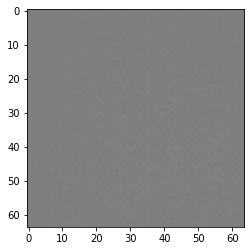

In [18]:
# Feed noise into G and see what we get

test_img = g(rand_noise_vec)

print(test_img)

for img in test_img:
  plt.imshow((img+1)/2)

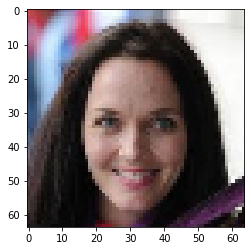

In [22]:
# Sampling random images from the dataset

def get_image_samples(n_samples):
  return(ds[np.random.randint(ds.shape[0], size=n_samples)])

plt.imshow((get_image_samples(10)[1]+1)/2)

In [20]:
# Test D

print(d(get_image_samples(1)))

tf.Tensor([[0.5114478]], shape=(1, 1), dtype=float32)


In [17]:
g = Generator()
d = Discriminator()

Model: "DCGAN_Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_2 (Dense)             (None, 2048)              206848    
                                                                 
 batch_normalization_4 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 8, 8, 64)         204864    
 ranspose)                                                       
                                                                 
 batch_normalization_5 (Batc  (None, 8, 8, 64)     

In [109]:
g = Generator()
d = Discriminator()

# Training loop

EPOCHS = 100
D_STEPS = 2
G_STEPS = 1
BATCH_SIZE = 128

# Set seed
np.random.seed(1)

# Optimizers
# d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
# g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

# Losses

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Format from https://www.tensorflow.org/tutorials/generative/dcgan:
def d_loss(real_predictions, fake_predictions):

  print(real_predictions)
  print(fake_predictions)

  # Label all real predictions' ground truth as 1, compute b-crossentropy
  real_loss = cross_entropy(tf.ones_like(real_predictions), 
                                                   real_predictions)
  # Label all fake predictions' ground truth as 0, compute b-crossentropy
  fake_loss = cross_entropy(tf.zeros_like(fake_predictions),
                                                   fake_predictions)
  # Sum and return losses
  # print(real_loss + fake_loss)
  # for i in real_loss:
  #   print(i)
  # for i in fake_loss:
  #   print(i)
  # print(real_loss)
  # print(fake_loss)
  loss = real_loss + fake_loss
  return loss
  # return fake_loss
  # return real_loss

  # return real_loss

def g_loss(d_values):

  # Binary Crossentropy between the Discriminator outputs and 1 (which we'd like 
  # the Discriminator outputs to be)
  loss = tf.keras.losses.BinaryCrossentropy()(tf.ones_like(d_values),
                                              d_values)
  return loss

# Training step definitions
# Compiled for training

@tf.function
def d_train_step(data_examples):

  with tf.GradientTape() as d_tape:

    # Sample m noise samples
    noise_samples = get_noise_samples(BATCH_SIZE)

    # Get Generator examples from the noise
    g_examples = g(noise_samples)

    # Sample real examples from dataset
    # data_examples = get_image_samples(BATCH_SIZE)

    # Run Discriminator and get loss
    loss = d_loss(d(data_examples, training=True), d(g_examples, training=True))

  # Get all Discriminator gradients with GradientTape
  d_grad = d_tape.gradient(loss, d.trainable_variables)
  print('dgrad:', d_grad)

  # Apply gradients to model, zipping gradients with corresponding variables
  d_optimizer.apply_gradients(zip(d_grad, d.trainable_variables))

  print('d_step')

@tf.function
def g_train_step():

  # All steps of the process must be within for backpropagation to work
  with tf.GradientTape() as g_tape:

    # Sample m noise samples
    noise_samples = get_noise_samples(BATCH_SIZE)

    # Get Generator (fake) examples from the noise
    g_examples = g(noise_samples)

    # Run discriminator on generated samples
    d_values = d(g_examples, training=True)

    # Get loss
    loss = g_loss(d_values)

  # Use GradientTape to get all Generator gradients
  g_grad = g_tape.gradient(loss, g.trainable_variables)

  # Apply gradients
  g_optimizer.apply_gradients(zip(g_grad, g.trainable_variables))

@tf.function
def train_step():

  print('tstep')

  for j in range(D_STEPS):
    
    for batch in dataset:
      # Train Discriminator to distinguish between the two
      d_train_step(batch)

  for j in range(G_STEPS):

    for batch in range(len(dataset)):
      # Train Generator to maximize the probability of tricking the discriminator
      g_train_step()


Model: "DCGAN_Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_35 (InputLayer)       [(None, 100)]             0         
                                                                 
 dense_34 (Dense)            (None, 16384)             1654784   
                                                                 
 batch_normalization_52 (Bat  (None, 16384)            65536     
 chNormalization)                                                
                                                                 
 reshape_17 (Reshape)        (None, 4, 4, 1024)        0         
                                                                 
 conv2d_transpose_68 (Conv2D  (None, 8, 8, 512)        13107712  
 Transpose)                                                      
                                                                 
 batch_normalization_53 (Bat  (None, 8, 8, 512)    

In [110]:
# Train

def train(EPOCHS):

  for i in range(EPOCHS):

    train_step()
    print("EPOCH " + str(i))

train(10)

tstep
Tensor("DCGAN_Discriminator/tf.math.sigmoid_17/Sigmoid:0", shape=(None, 1), dtype=float32)
Tensor("DCGAN_Discriminator/tf.math.sigmoid_17/Sigmoid_1:0", shape=(128, 1), dtype=float32)
dgrad: [<tf.Tensor 'AddN_3:0' shape=(5, 5, 3, 128) dtype=float32>, <tf.Tensor 'AddN_4:0' shape=(128,) dtype=float32>, <tf.Tensor 'AddN_5:0' shape=(5, 5, 128, 256) dtype=float32>, <tf.Tensor 'AddN_6:0' shape=(256,) dtype=float32>, <tf.Tensor 'AddN_7:0' shape=(5, 5, 256, 512) dtype=float32>, <tf.Tensor 'AddN_8:0' shape=(512,) dtype=float32>, <tf.Tensor 'AddN_9:0' shape=(5, 5, 512, 1024) dtype=float32>, <tf.Tensor 'AddN_10:0' shape=(1024,) dtype=float32>, <tf.Tensor 'AddN_11:0' shape=(16384, 1) dtype=float32>, <tf.Tensor 'AddN_12:0' shape=(1,) dtype=float32>]
d_step
Tensor("DCGAN_Discriminator/tf.math.sigmoid_17/Sigmoid:0", shape=(None, 1), dtype=float32)
Tensor("DCGAN_Discriminator/tf.math.sigmoid_17/Sigmoid_1:0", shape=(128, 1), dtype=float32)
dgrad: [<tf.Tensor 'AddN_3:0' shape=(5, 5, 3, 128) dtype=f

tf.Tensor(
[[[[ 1.12502382e-03 -2.04627169e-03 -2.49071489e-03]
   [ 2.27413070e-03 -1.77720014e-03 -2.09537288e-03]
   [ 9.13575175e-04 -3.05886636e-03 -2.07877089e-03]
   ...
   [ 2.38127494e-03 -2.35313992e-03 -2.37391610e-03]
   [ 5.57251100e-04 -2.89784861e-03 -1.45730085e-03]
   [ 1.39938924e-03 -2.09562248e-03 -3.43269808e-03]]

  [[ 2.71131610e-03 -4.18751093e-04 -2.55604438e-03]
   [ 3.08001391e-03 -3.89338424e-03 -3.56943742e-03]
   [ 3.32979369e-03 -7.12959911e-04 -9.36175813e-04]
   ...
   [ 5.23495395e-03 -7.28471903e-03 -4.16375324e-03]
   [ 3.59921902e-03 -1.49556925e-03 -1.42948213e-03]
   [ 4.17355960e-03 -5.73009625e-03 -3.10708187e-03]]

  [[ 1.08557683e-03 -2.79204221e-03 -2.95645883e-03]
   [ 1.22361118e-03 -1.36034528e-03 -5.57720254e-04]
   [ 3.87150445e-04 -4.04730439e-03 -3.04922066e-03]
   ...
   [ 3.86425992e-04 -1.72130635e-03 -1.13695301e-03]
   [ 1.18085765e-04 -4.71739471e-03 -3.85239278e-03]
   [ 1.30999659e-03 -3.83028225e-03 -4.70717001e-04]]

  ...

 

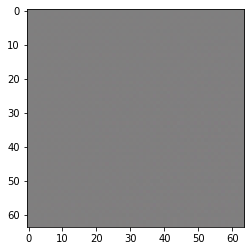

In [25]:
test_img = g(rand_noise_vec)

print(test_img)

for img in test_img:
  plt.imshow((img + 1)/2)

In [299]:
test_g_sample = g(get_noise_samples(1))
test_real_sample = get_image_samples(1)

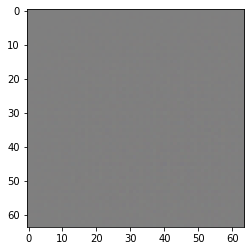

In [278]:
plt.imshow((test_g_sample[0]+1)/2)

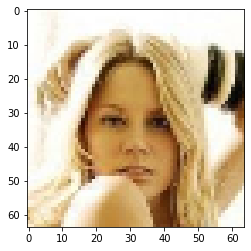

In [300]:
plt.imshow((test_real_sample[0]+1)/2)

In [111]:
# Discriminator test

# Note: Since the generator is trained after the discriminator during the sequence, 

fake = 0
real = 0

for i in range(200):
  test_g_sample = g(get_noise_samples(1))
  test_real_sample = get_image_samples(1)
  fake+=d(test_g_sample)
  real+=d(test_real_sample)

print(fake/200.0)
print(real/200.0)

# print(d(test_g_sample))

# print(d(test_real_sample))

# print(d(g(get_noise_samples(1))))

# print(d(get_image_samples(1)))

tf.Tensor([[1.]], shape=(1, 1), dtype=float32)
tf.Tensor([[1.]], shape=(1, 1), dtype=float32)


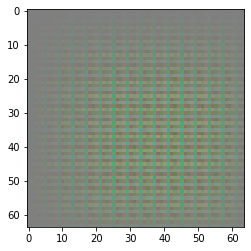

In [112]:
plt.imshow((g(get_noise_samples(1))[0]+1)/2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


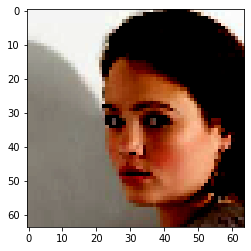

In [ ]:
plt.imshow(data_examples[0])

In [ ]:
# Prepare data

real_ds = tf.keras.utils.image_dataset_from_directory('/content/CelebA/img_align_celeba/', 
                                                      validation_split=0.1, 
                                                      subset='training', seed=1)


Found 0 files belonging to 0 classes.
Using 0 files for training.


ValueError: ignored

In [ ]:
# Load dataset

import tensorflow_datasets as tfds

ds = tfds.load('celeb_a', shuffle_files=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

KeyError: ignored